# Библиотеки

In [1]:
!pip install networkx matplotlib causality causalgraphicalmodels dowhy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.9 MB/s eta 0:00:00
  Created wheel for causality: filename=causality-0.0.10-py3-none-any.whl size=18926 sha256=05087b9586d8de264ad18f7745fb638d5b57e94f550b8c62428bf6d5f1ba5ebb
  Stored in directory: /root/.cache/pip/wheels/ff/fd/fa/ca32021af54fa54ec4e3cf5046cbe308dbb9068aa2d5dc2217
Successfully built causality
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.4
    Uninstalling Cython-3.0.4:
      Successfully uninstalled Cython-3.0.4


In [1]:
from zlib import crc32

import numpy as np
import scipy.stats as st
import networkx as nx
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import pandas as pd
import seaborn as sns

from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
from causalgraphicalmodels import CausalGraphicalModel

import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

Выше ловим ошибку на модуль collections (-> collections.abc в версии python3.10).

Исправляется только вручную, так как при downgrad'e до python3.9 импорт модулей требует перезагрузки, а перезагрузка крашит нужную версию python -> замкнутый круг.

# Код генерации выборки

In [2]:
import re
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code)
    g = nx.DiGraph(nodes=[str(i) for i in range(5)])
    edges = []
    for i in range(5):
        for j in range(5):
            if i == j:
                continue
            if rs.uniform() > 0.35:
                g.add_edge(str(i),str(j))
                if not nx.is_directed_acyclic_graph(g):
                    g.remove_edge(str(i),str(j))
                else:
                    edges.append((str(i), str(j)))

    edges = [[int(a[0]), int(a[1])] for a in edges]
    edges = np.array(edges).astype(np.uint32)
    return edges

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [3]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task

Enter your mail: egorov.sa@phystech.edu


{'mail': 'egorov.sa@phystech.edu',
 'id': 1581189463,
 'data': array([[0, 3],
        [0, 4],
        [1, 4],
        [2, 1],
        [2, 3],
        [2, 4],
        [3, 1]], dtype=uint32)}

# Работа с выборкой

In [4]:
data = pd.DataFrame(task['data'])
data.sample(5)

,0,1
6,3,1
3,2,1
0,0,3
1,0,4
2,1,4


In [5]:
data = data.astype(int)
data

,0,1
0,0,3
1,0,4
2,1,4
3,2,1
4,2,3
5,2,4
6,3,1


In [6]:
pd.unique(data[0]), pd.unique(data[1])

(array([0, 1, 2, 3]), array([3, 4, 1]))

In [7]:
edges = [tuple(tuple(map(str, x))) for x in data.to_numpy()]
edges

[('0', '3'),
 ('0', '4'),
 ('1', '4'),
 ('2', '1'),
 ('2', '3'),
 ('2', '4'),
 ('3', '1')]

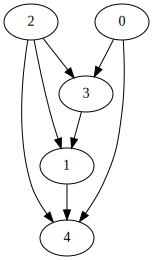

In [8]:
from causalgraphicalmodels import CausalGraphicalModel

G = CausalGraphicalModel(nodes=['0', '1', '2', '3', '4'], edges=edges)
G.draw()

# Задание

### Количество условно-независимых пар событий внутри графа

In [9]:
len(G.get_all_independence_relationships())

3

### Количество цепочек (из 3 вершин) внутри графа

[Source](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/)

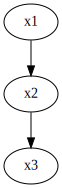

In [10]:
from causalgraphicalmodels.examples import fork, chain, collider

chain.draw()

Из рисунка видно, что **4**.

### Количество вилок внутри графа

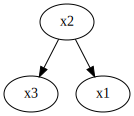

In [11]:
fork.draw()

Из рисунка видно, что **8**.

### Количество коллайдеров внутри графа

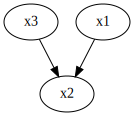

In [12]:
collider.draw()

Из рисунка видно, что **7**.